In [ ]:
cd \drive/MyDrive/

/content/drive/MyDrive


In [ ]:
cd Internship\ Cilans

/content/drive/MyDrive/Internship Cilans


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [ ]:
#tf.keras.preprocessing.image_dataset_from_directory
#Loading Dataset...
batch_size = 16
img_height = 1280
img_width = 1280
data_dir="/content/drive/MyDrive/Internship Cilans/B_W Dataset(good and fault) Arducam IMX219/"
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=21,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 2175 files belonging to 2 classes.
Using 1740 files for training.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['Bad_bw', 'Good_bw']


In [ ]:
#Validation dataset
validation_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=21,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 2175 files belonging to 2 classes.
Using 435 files for validation.


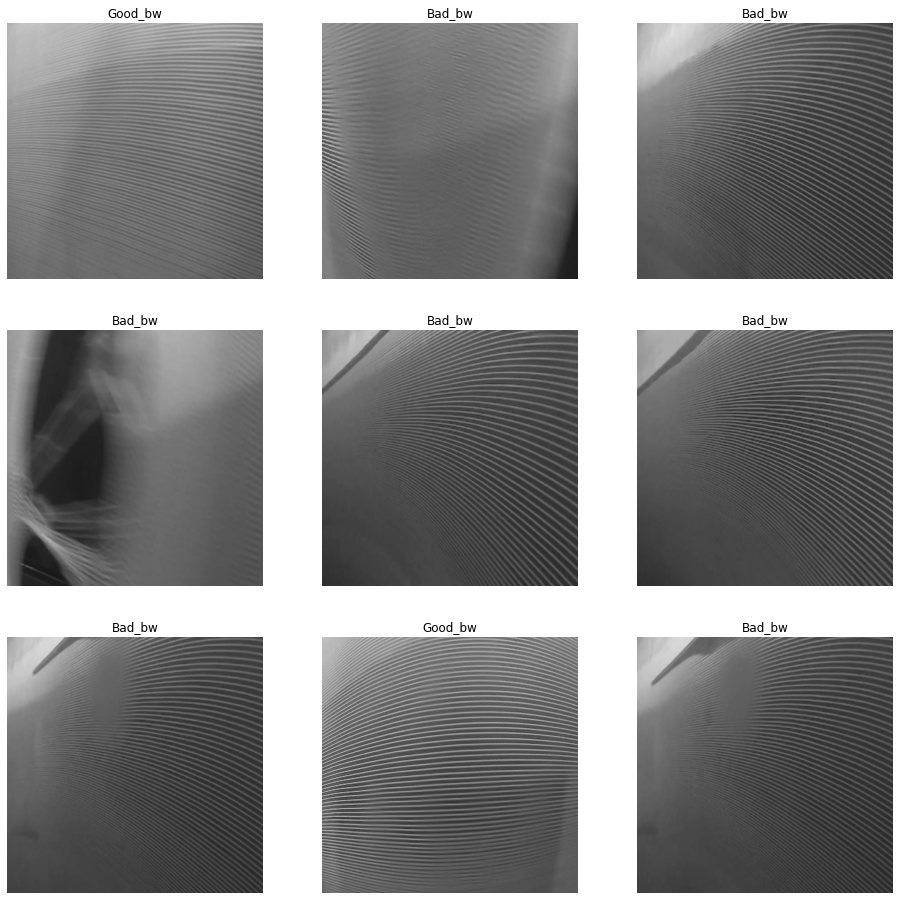

In [ ]:
#Visualizing figures from training set
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 16))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
#resizing
size = (480, 480)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
#test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [ ]:
#data augmentation
from tensorflow import keras
from tensorflow.keras import layers

'''data_augmentation = keras.Sequential(
    [layers.RandomFlip("horizontal"), layers.RandomRotation(0.1),]
)'''
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.1),
])

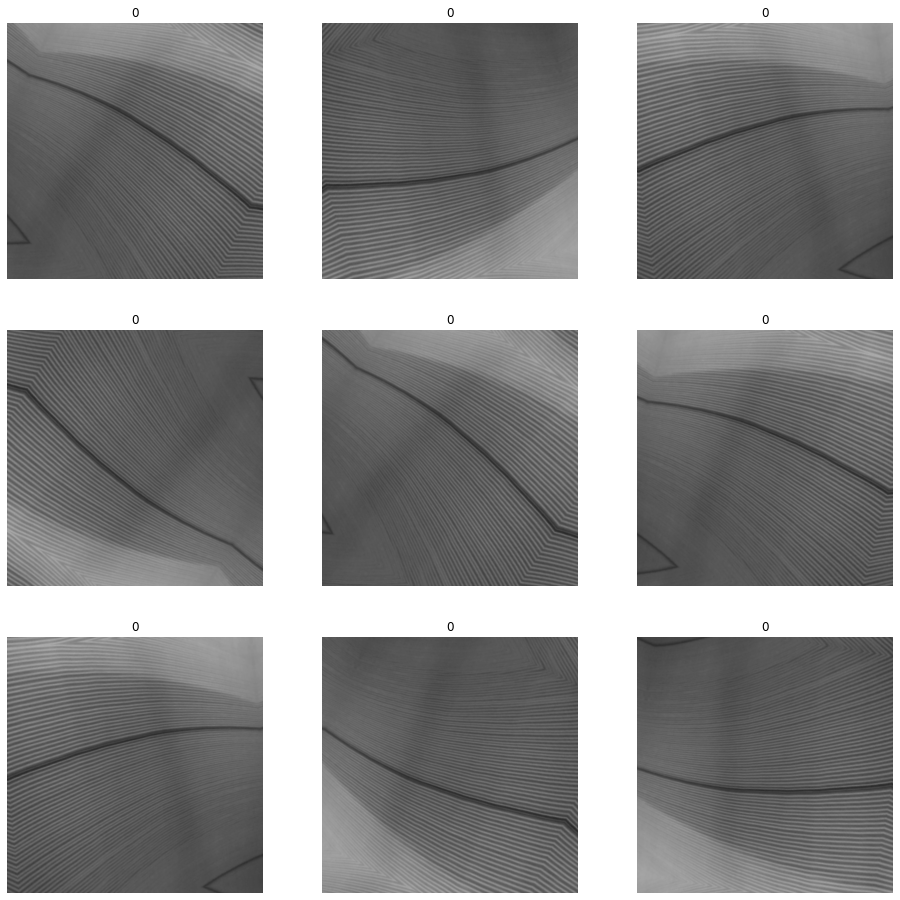

In [ ]:

for images, labels in train_ds.take(1):
    plt.figure(figsize=(16, 16))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.title(int(labels[0]))
        plt.axis("off")

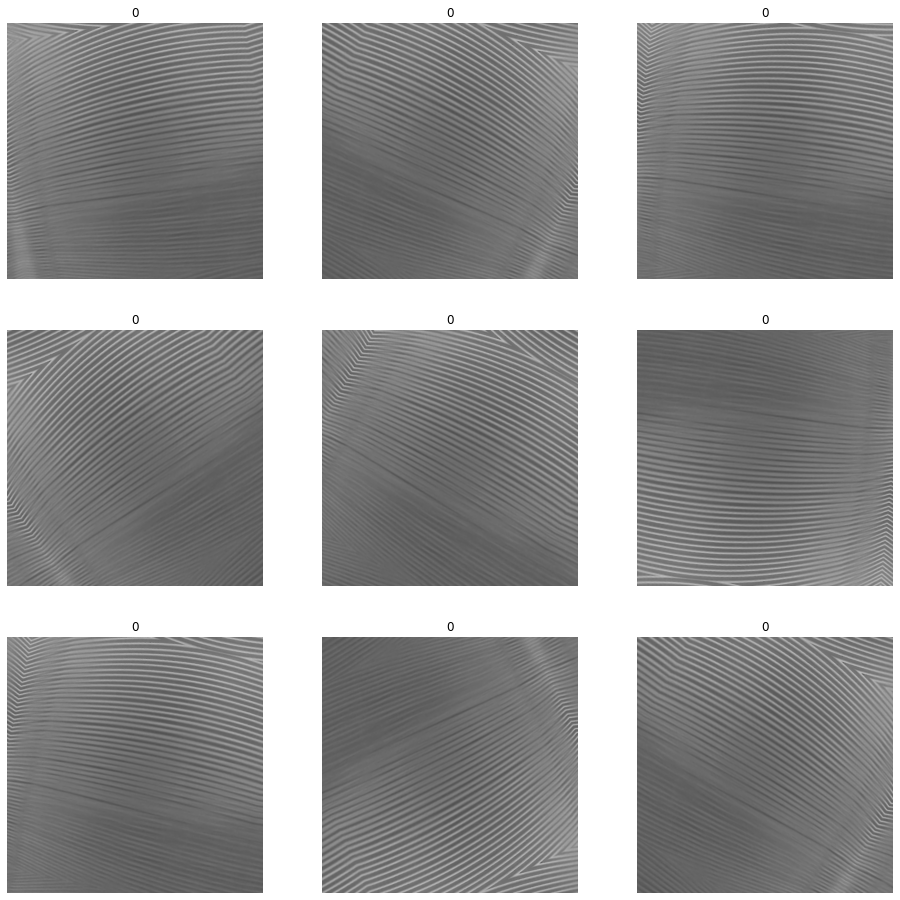

In [ ]:

for images, labels in train_ds.take(1):
    plt.figure(figsize=(16, 16))
    first_image = images[1]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("uint8"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(size[0], size[1], 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(size[0], size[1], 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout

from tensorflow.keras.backend import sigmoid

outputs = keras.layers.Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs, outputs)

model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 480, 480, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 480, 480, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 480, 480, 3)       0         
                                                                 
 xception (Functional)       (None, 15, 15, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0      

In [ ]:
#first training
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 20
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/20
109/109 [==============================] - 203s 2s/step - loss: 0.3912 - binary_accuracy: 0.8626 - val_loss: 0.3584 - val_binary_accuracy: 0.8897
Epoch 2/20
109/109 [==============================] - 63s 554ms/step - loss: 0.2372 - binary_accuracy: 0.9374 - val_loss: 0.3086 - val_binary_accuracy: 0.8966
Epoch 3/20
109/109 [==============================] - 54s 474ms/step - loss: 0.1974 - binary_accuracy: 0.9397 - val_loss: 0.2680 - val_binary_accuracy: 0.9126
Epoch 4/20
109/109 [==============================] - 55s 480ms/step - loss: 0.1714 - binary_accuracy: 0.9506 - val_loss: 0.2579 - val_binary_accuracy: 0.8943
Epoch 5/20
109/109 [==============================] - 63s 553ms/step - loss: 0.1585 - binary_accuracy: 0.9546 - val_loss: 0.2314 - val_binary_accuracy: 0.9195
Epoch 6/20
109/109 [==============================] - 54s 476ms/step - loss: 0.1450 - binary_accuracy: 0.9506 - val_loss: 0.2240 - val_binary_accuracy: 0.9080
Epoch 7/20
109/109 [============================

In [ ]:
  # Save the model
from datetime import datetime
now = datetime.now()
now = now.strftime("%Y%m%d_%H%M%S")
model_name = str(now)+"sigmoid with false logits"+"_model_" + '.h5'
model.save(model_name)

In [ ]:
#fine tuning
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 10
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 480, 480, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 480, 480, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 480, 480, 3)       0         
                                                                 
 xception (Functional)       (None, 15, 15, 2048)      20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                             

In [ ]:
test_loss, test_acc = model.evaluate(validation_ds, verbose=2)

28/28 - 17s - loss: 0.0058 - binary_accuracy: 0.9954 - 17s/epoch - 621ms/step


In [ ]:
test_acc*100

99.54022765159607

In [ ]:
test_loss, test_acc = model.evaluate(validation_ds, verbose=2)

28/28 - 13s - loss: 0.0090 - binary_accuracy: 0.9954 - 13s/epoch - 475ms/step


In [ ]:
test_acc*100

99.54022765159607